# [Refine Use of Explored NTD Variables #1646](https://github.com/cal-itp/data-analyses/issues/1646)

Question or Goal:

1. Mode & Service: We previously used these to define the grain of the data. These should be used for classifying/model-fitting.
    - There are many modes: Can we group modes so there are fewer of them (e.g. fixed-guideway vs not)? Too many dummy variables for a category leads to overfitting/too many clusters.
    - What's the best way to use Service? Is it as a dummy variable? Is it numeric "proportion of service(VRH or M)" that's directly operated? Explore the impacts of both.


2. If we group by only Agency (flattening, fewer rows), how do we aggregate the other classification variables before we normalize them? Is adding sufficient? Do we need to average any?


3. Are there ways to get more interactive/easy-to-read visualizations?
    - If it takes significant time, break this one out

## Terms
**Example**:
- You could think of an example as analogous to a `single row` in a spreadsheet.

**Feature**:
- Features are the values that a supervised model uses to predict the label.
- In a weather model that predicts rainfall, the features could be `latitude, longitude, temperature, humidity, cloud coverage, wind direction, and atmospheric pressure`.
- An input variable to a machine learning model. An example consists of one or more features. For instance, suppose you are training a model to determine the influence of weather conditions on student test scores. The following table shows three examples, each of which contains three features and one label:

**Label**:
- The label is the "answer," or the value we want the model to predict.
- In a weather model that predicts rainfall, the label would be `rainfall amount`.
- In supervised machine learning, the "answer" or "result" portion of an example. Each labeled example consists of one or more features and a label. For example, in a spam detection dataset, the label would probably be either "spam" or "not spam." In a rainfall dataset, the label might be the amount of rain that fell during a certain period.

In [1]:
import pandas as pd

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

## read in data

In [2]:
transit_metrics = pd.read_parquet(
    f"gs://calitp-analytics-data/data-analyses/ntd/raw_transit_performance_metrics_data.parquet"
)

In [3]:
transit_metrics.head()
# grain: each row is agency, mode, service per year

,agency_name,agency_status,city,mode,service,ntd_id,reporter_type,reporting_module,state,primary_uza_name,year,upt,vrh,vrm,opexp_total,RTPA,_merge
0,City of Porterville (COLT) - Transit Department,Active,Porterville,Demand Response,Purchased Transportation,90198,Building Reporter,Urban,CA,"Porterville, CA",2019,13112,2997,43696,572799,Tulare County Association of Governments,both
1,City of Porterville (COLT) - Transit Department,Active,Porterville,Demand Response,Purchased Transportation,90198,Building Reporter,Urban,CA,"Porterville, CA",2020,11523,3669,48138,686165,Tulare County Association of Governments,both
2,City of Porterville (COLT) - Transit Department,Active,Porterville,Bus,Purchased Transportation,90198,Building Reporter,Urban,CA,"Porterville, CA",2018,635648,50140,700127,3460906,Tulare County Association of Governments,both
3,City of Porterville (COLT) - Transit Department,Active,Porterville,Bus,Purchased Transportation,90198,Building Reporter,Urban,CA,"Porterville, CA",2021,145215,21208,244230,2657959,Tulare County Association of Governments,both
4,City of Porterville (COLT) - Transit Department,Active,Porterville,Demand Response,Purchased Transportation,90198,Building Reporter,Urban,CA,"Porterville, CA",2021,29380,9565,126604,952031,Tulare County Association of Governments,both


## Get NTD data from PUC analysis
I queried data from `mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_{metric}`


In [4]:
from calitp_data_analysis.sql import get_engine

In [5]:
db_engine = get_engine()

metric_list = [
    # "pmt",
    "upt",
    "vrh",
    "opexp_total"
]

# empty list for appending DFs
df_list = []
with db_engine.connect() as connection:
    for metric in metric_list:
        query = f"""
        SELECT
          ntd_id,
          source_agency,
          agency_status,
          primary_uza_name,
          uza_population,
          uza_area_sq_miles,
          year,
          SUM({metric}) AS total_{metric},
        FROM
          `cal-itp-data-infra.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_{metric}`
        WHERE
          source_state = "CA"
          AND year >= 2018
        GROUP BY
          ntd_id,
          source_agency,
          agency_status,
          year,
          primary_uza_name,
          uza_population,
          uza_area_sq_miles
        """
        # create df
        metric = pd.read_sql(query,connection) 
        
        # append df to list
        df_list.append(metric)

# unpack list into separate DFs
ntd_upt, ntd_vrh, ntd_opex = df_list

In [6]:
merge_on_col=["ntd_id", "year","source_agency","agency_status","primary_uza_name","uza_population","uza_area_sq_miles"]
merge_1 = ntd_opex.merge(ntd_upt, on=merge_on_col, how = "inner")

ntd_metrics_merge = merge_1.merge(ntd_vrh, on=merge_on_col, how = "inner")

In [7]:
ntd_metrics_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1614 entries, 0 to 1613
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ntd_id             1524 non-null   object 
 1   source_agency      1614 non-null   object 
 2   agency_status      1614 non-null   object 
 3   primary_uza_name   1614 non-null   object 
 4   uza_population     1614 non-null   int64  
 5   uza_area_sq_miles  1614 non-null   float64
 6   year               1614 non-null   int64  
 7   total_opexp_total  1291 non-null   float64
 8   total_upt          1291 non-null   float64
 9   total_vrh          1291 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 138.7+ KB


## Classify feature columns

In [8]:
# number of unique values for each column and % of 
for col in transit_metrics.columns:
    print(f"{col}: {transit_metrics[col].nunique()} unique values. {round((transit_metrics[col].nunique()/len(transit_metrics))*100,2)} % of unique values to total rows")

agency_name: 168 unique values. 8.03 % of unique values to total rows
agency_status: 2 unique values. 0.1 % of unique values to total rows
city: 124 unique values. 5.93 % of unique values to total rows
mode: 15 unique values. 0.72 % of unique values to total rows
service: 4 unique values. 0.19 % of unique values to total rows
ntd_id: 168 unique values. 8.03 % of unique values to total rows
reporter_type: 4 unique values. 0.19 % of unique values to total rows
reporting_module: 2 unique values. 0.1 % of unique values to total rows
state: 1 unique values. 0.05 % of unique values to total rows
primary_uza_name: 49 unique values. 2.34 % of unique values to total rows
year: 6 unique values. 0.29 % of unique values to total rows
upt: 2036 unique values. 97.37 % of unique values to total rows
vrh: 2018 unique values. 96.51 % of unique values to total rows
vrm: 2046 unique values. 97.85 % of unique values to total rows
opexp_total: 2068 unique values. 98.9 % of unique values to total rows
RTPA:

In [9]:
# Feature groups
id_cols = [ # exclude from clustering
    "agency_name",
    "city",
    "ntd_id",
    "state",
    "primary_uza_name",
    "RTPA",
    "reporter_type"
]

categorical_cols =[ # include in clustering
    "mode", # 15 unique values
    "service" # 4
]

numerical_cols = [ # include in clustering
    "upt",
    "vrh",
    "vrm",
    "opexp_total"
]

other_cols = [ # exclude in clustering
    "agency_status"
    "year",
    "reporting_module",
    "_merge"
]

## 2. Mode & Service

### Unique `Mode` sub-categories
Previous research papers categorized mode by have/not have "dedicated right of way"/ "fixed guideway".

In [10]:
list(transit_metrics["mode"].unique())

['Demand Response',
 'Bus',
 'Streetcar',
 'Heavy Rail',
 'Demand Response Taxi',
 'Commuter Bus',
 'Hybrid Rail',
 'Commuter Rail',
 'Vanpool',
 'Bus Rapid Transit',
 'Cable Car',
 'Light Rail',
 'Trolleybus',
 'Ferryboats',
 'Monorail / Automated Guideway']

In [11]:
fixed_guideway = [
    "Streetcar",
    "Heavy Rail",
    "Hybrid Rail",
    "Commuter Rail",
    "Cablecar",
    "Light Rail"
]

other =[
    "Trolleybus",
    "Ferryboats"
]

nonfixed_guideway = [
    "Demand Response",
    "Bus",
    "Demand Response Taxi",
    "Commuter Bus",
    "Vanpool",
    "Bus Rapid Transit",
    "Monorail / Automated Guideway"
]

### Unique `Service` values

In [12]:
transit_metrics["service"].value_counts()

Purchased Transportation                                     1480
Directly Operated                                             523
Purchased Transportation - Taxi                                74
Purchased Transportation - Transportation Network Company      14
Name: service, dtype: int64

## 3. "Flattening" data
If we group by only Agency (flattening, fewer rows), how do we aggregate the other classification variables before we normalize them? Is adding sufficient? Do we need to average any?

In [13]:
# agg the numerical row, end with each row being an agency
group_id = transit_metrics.groupby(id_cols).agg(
    {col: "sum" for col in numerical_cols} 
).reset_index()

In [14]:
# agg the numerical row, end with each row being an agency
group_cat = transit_metrics.groupby(categorical_cols).agg(
    {col: "sum" for col in numerical_cols} 
).reset_index()

In [15]:
# double checking aggregation works
(transit_metrics[transit_metrics["ntd_id"]=="90211"]["opexp_total"].sum() == group_id[group_id["ntd_id"]=="90211"]["opexp_total"].sum(),
transit_metrics[transit_metrics["mode"]=="Bus"]["opexp_total"].sum() == group_cat[group_cat["mode"]=="Bus"]["opexp_total"].sum())

(True, True)

In [16]:
display("group_id",
    group_id.shape,
    group_id.head(),
    )

'group_id'

(168, 11)

,agency_name,city,ntd_id,state,primary_uza_name,RTPA,reporter_type,upt,vrh,vrm,opexp_total
0,Access Services (AS),El Monte,90157,CA,"Los Angeles--Long Beach--Anaheim, CA",Southern California Association of Governments,Full Reporter,21100712,11073631,195345317,992266445
1,Alameda-Contra Costa Transit District,Oakland,90014,CA,"San Francisco--Oakland, CA",Metropolitan Transportation Commission,Full Reporter,238095061,12968803,140963319,2864051248
2,Altamont Corridor Express (ACE),Stockton,90182,CA,"Stockton, CA",San Joaquin Council of Governments,Full Reporter,4923384,141171,5573755,143295615
3,Anaheim Transportation Network (ATN),Anaheim,90211,CA,"Los Angeles--Long Beach--Anaheim, CA",Southern California Association of Governments,Full Reporter,40740395,976178,6528424,82415962
4,Antelope Valley Transit Authority (AVTA),Lancaster,90121,CA,"Palmdale--Lancaster, CA",Southern California Association of Governments,Full Reporter,10230960,1222451,20620573,166805222


In [17]:
display("group_cat",
    group_cat.shape,
    group_cat.head()
)

'group_cat'

(25, 6)

,mode,service,upt,vrh,vrm,opexp_total
0,Bus,Directly Operated,2952883383,109698885,1187304414,21064786925
1,Bus,Purchased Transportation,636746541,45722527,581552826,5000145202
2,Bus Rapid Transit,Directly Operated,40599424,828979,11343877,251967151
3,Cable Car,Directly Operated,21089173,551837,1139285,373274268
4,Commuter Bus,Directly Operated,11604823,769809,16510747,195171589


### compared to `ntd_metrics_merge`

In [18]:
ntd_metrics_merge.head()

,ntd_id,source_agency,agency_status,primary_uza_name,uza_population,uza_area_sq_miles,year,total_opexp_total,total_upt,total_vrh
0,90198,City of Porterville (COLT) - Transit Department,Active,"Porterville, CA",69862,16.35,2021,3609990.0,174595.0,30773.0
1,90198,City of Porterville (COLT) - Transit Department,Active,"Porterville, CA",69862,16.35,2023,NaN,NaN,NaN
2,90198,City of Porterville (COLT) - Transit Department,Active,"Porterville, CA",69862,16.35,2019,4014118.0,635559.0,52834.0
3,90198,City of Porterville (COLT) - Transit Department,Active,"Porterville, CA",69862,16.35,2018,4025065.0,648649.0,52799.0
4,90198,City of Porterville (COLT) - Transit Department,Active,"Porterville, CA",69862,16.35,2020,4212765.0,522056.0,47356.0


In [19]:
group_id[group_id["ntd_id"]=="90211"]["opexp_total"].sum() == ntd_metrics_merge[ntd_metrics_merge["ntd_id"]=="90211"]["total_opexp_total"].sum()

True

In [20]:
id_cols

['agency_name',
 'city',
 'ntd_id',
 'state',
 'primary_uza_name',
 'RTPA',
 'reporter_type']

In [21]:
merge_group = ntd_metrics_merge.groupby(
    ["ntd_id","source_agency","primary_uza_name","uza_population","uza_area_sq_miles"]
).agg({
    "total_opexp_total":"sum",
    "total_upt":"sum",
    "total_vrh":"sum"
}).reset_index()

In [22]:
merge_group.head()

,ntd_id,source_agency,primary_uza_name,uza_population,uza_area_sq_miles,total_opexp_total,total_upt,total_vrh
0,90003,San Francisco Bay Area Rapid Transit District ...,"San Francisco--Oakland, CA",3515933,513.80,4.109168e+09,455096497.0,13481404.0
1,90004,Golden Empire Transit District (GET),"Bakersfield, CA",570235,132.12,1.938957e+08,27369380.0,1871722.0
2,90006,Santa Cruz Metropolitan Transit District (SCMTD),"Santa Cruz, CA",169038,60.45,2.828370e+08,20980309.0,1318828.0
3,90007,City of Modesto (MAX),"Modesto, CA",357301,70.38,7.735015e+07,8170544.0,809165.0
4,90008,City of Santa Monica (BBB) - Department of Tra...,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,4.715525e+08,55239107.0,2879128.0


# Google Machine Learning Course - Numerical Data

https://developers.google.com/machine-learning/crash-course/numerical-data


## 1. Before creating feature vectors, we recommend studying numerical data in two ways:
- Visualize your data in plots or graphs.
- Get statistics about your data.

**Visualize your data**

Graphs can help you find anomalies or patterns hiding in the data. Therefore, before getting too far into analysis, look at your data graphically, either as scatter plots or histograms. View graphs not only at the beginning of the data pipeline, but also throughout data transformations. Visualizations help you continually check your assumptions.

We recommend working with pandas for visualization:

Working with Missing Data (pandas Documentation)
Visualizations (pandas Documentation)

Note that certain visualization tools are optimized for certain data formats. A visualization tool that helps you evaluate protocol buffers may or may not be able to help you evaluate CSV data.

<Axes: >

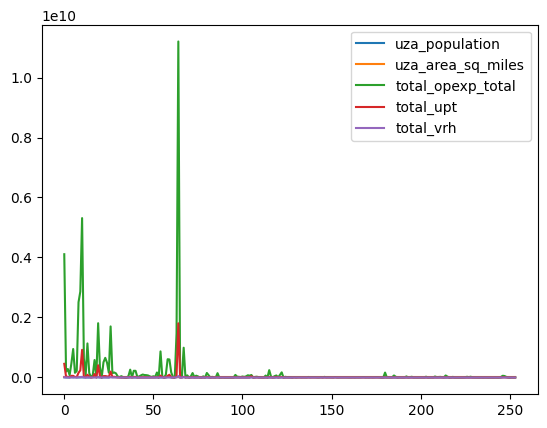

In [23]:
merge_group.plot()

**Statistically evaluate your data**

Beyond visual analysis, we also recommend evaluating potential features and labels mathematically, gathering basic statistics such as:

- mean and median
- standard deviation
- the values at the quartile divisions: the 0th, 25th, 50th, 75th, and 100th percentiles. The 0th percentile is the minimum value of this column; the 100th percentile is the maximum value of this column. (The 50th percentile is the median.)

In [26]:
merge_group.describe(include = "all")

,ntd_id,source_agency,primary_uza_name,uza_population,uza_area_sq_miles,total_opexp_total,total_upt,total_vrh
count,254,254,254,2.540000e+02,254.000000,2.540000e+02,2.540000e+02,2.540000e+02
unique,254,253,52,NaN,NaN,NaN,NaN,NaN
top,90003,Los Angeles County Metropolitan Transportation...,"Los Angeles--Long Beach--Anaheim, CA",NaN,NaN,NaN,NaN,NaN
freq,1,2,79,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,5.334673e+06,614.008622,1.848787e+08,2.201347e+07,9.729054e+05
std,NaN,NaN,NaN,4.894046e+06,712.728474,8.718196e+08,1.340215e+08,3.806733e+06
min,NaN,NaN,NaN,5.428700e+04,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,NaN,NaN,NaN,3.761170e+05,14.667500,2.377464e+06,8.669525e+04,2.092075e+04
50%,NaN,NaN,NaN,4.357850e+06,132.120000,9.338178e+06,5.207645e+05,1.047775e+05
75%,NaN,NaN,NaN,1.223738e+07,1636.830000,4.795623e+07,3.758004e+06,4.498462e+05


**Find outliers**

An outlier is a value distant from most other values in a feature or label. Outliers often cause problems in model training, so finding outliers is important.

When the delta between the `0th and 25th percentiles` differs significantly from the delta between the `75th and 100th percentiles`, the dataset probably contains outliers.

Examine the delta between the `mean and standard deviation`. Typically you want to see the standard deviation to be smaller than the mean.

Note: Don't over-rely on basic statistics. Anomalies can also hide in seemingly well-balanced data.
Outliers can fall into any of the following categories:

- The outlier is due to a mistake. For example, perhaps an experimenter mistakenly entered an extra zero, or perhaps an instrument that gathered data malfunctioned. You'll generally delete examples containing mistake outliers.
- The outlier is a legitimate data point, not a mistake. In this case, will your trained model ultimately need to infer good predictions on these outliers?
  - If yes, keep these outliers in your training set. After all, outliers in certain features sometimes mirror outliers in the label, so the outliers could actually help your model make better predictions. Be careful, extreme outliers can still hurt your model.
  - If no, delete the outliers or apply more invasive feature engineering techniques, such as clipping.

**Log scaling**

Log scaling computes the logarithm of the raw value. In theory, the logarithm could be any base; in practice, log scaling usually calculates the natural logarithm (ln).


Log scaling is helpful when the data conforms to a power law distribution. Casually speaking, a power law distribution looks as follows:

- Low values of X have very high values of Y.
- As the values of X increase, the values of Y quickly decrease. Consequently, high values of X have very low values of Y.

Movie ratings are a good example of a power law distribution. In the following figure, notice:

- A few movies have lots of user ratings. (Low values of X have high values of Y.)
- Most movies have very few user ratings. (High values of X have low values of Y.)
Log scaling changes the distribution, which helps train a model that will make better predictions.

In [ ]:
upt?

**Clipping**

Clipping is a technique to minimize the influence of extreme outliers. In brief, clipping usually caps (reduces) the value of outliers to a specific maximum value. Clipping is a strange idea, and yet, it can be very effective.

How can you minimize the influence of those extreme outliers? Well, the histogram is not an even distribution, a normal distribution, or a power law distribution. What if you simply cap or clip the maximum value of roomsPerPerson at an arbitrary value, say 4.0?

Clipping the feature value at 4.0 doesn't mean that your model ignores all values greater than 4.0. Rather, it means that all values that were greater than 4.0 now become 4.0. This explains the peculiar hill at 4.0. Despite that hill, the scaled feature set is now more useful than the original data.

**Wait a second! Can you really reduce every outlier value to some arbitrary upper threshold? When training a model, yes.**

You can also clip values after applying other forms of normalization. For example, suppose you use Z-score scaling, but a few outliers have absolute values far greater than 3. In this case, you could:

- Clip Z-scores greater than 3 to become exactly 3.
- Clip Z-scores less than -3 to become exactly -3.

In [ ]:
clip upt z-scores?